## Getting TC track and modifying it

### Import packages

In [183]:
import numpy as np
import matplotlib.pyplot as plt
from   pyproj import Proj
import shapely.geometry as shp
from shapely import affinity
from scipy import interpolate
import glob as gl
import geopandas as gpd
import cartopy.crs as ccrs

### Define some functions

In [240]:
def utm_proj_from_lon(lon_mean):
    """
    utm_from_lon - UTM zone for a longitude
    Not right for some polar regions (Norway, Svalbard, Antartica)
    :param float lon: longitude
    :return: UTM zone number
    :rtype: int
    
    :usage   x_utm,y_utm   = myProj(lon, lat  , inverse=False)
    :usage   lon, lat      = myProj(xutm, yutm, inverse=True)
    
    """
    zone =  np.floor( ( lon_mean + 180 ) / 6) + 1
    #print("Zone is " + str(zone))
    myProj        = Proj("+proj=utm +zone="+str(zone)+"K, +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
    return myProj


def interpolate_line(xin,yin,dl=None,num=None , closed = False):
    """
    xin,yin: input x and y
    dl  : every dl meter
    num : number of points to interpolate
    """
    xl = []
    yl = []
    
    x = np.array(xin).squeeze()
    y = np.array(yin).squeeze()
    
    if closed:
        #add the 1st point to last to make it a closed line
        x = np.r_[x,x[0]]
        y = np.r_[y,y[0]]
    
    points_temp = np.array(zip(x, y)).squeeze()
    line = shp.asLineString(points_temp)
    
    if dl is None:
       dl = line.length/int(num)
    
    if num is None:
       num = int(line.length//dl)
    
    for ir in range(num+1):
        dist = dl * ir
        #print dist
        xtmp,ytmp = line.interpolate(distance = dist, normalized = False).xy
        xl.append(xtmp)
        yl.append(ytmp)     
    
    xl = np.array(xl).squeeze()
    yl = np.array(yl).squeeze()
    return xl,yl

def distance(p1,p2):
    dis = np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
    #dis = np.hypot(p1[0]-p2[0],p1[1]-p2[1])
    return dis

def get_offset(p1,p2,d):
    x1 = p1[0]
    y1 = p1[1]
    x2 = p2[0]
    y2 = p2[1]
    if x1 == x2:
        dx = d
        dy = 0
    elif y1 == y2:
        dy = d
        dx = 0
    else: 
        # if z is the distance to your parallel curve,
        # then your delta-x and delta-y calculations are:
        #   z**2 = x**2 + y**2
        #   y = pslope * x
        #   z**2 = x**2 + (pslope * x)**2
        #   z**2 = x**2 + pslope**2 * x**2
        #   z**2 = (1 + pslope**2) * x**2
        #   z**2 / (1 + pslope**2) = x**2
        #   z / (1 + pslope**2)**0.5 = x
            
        # tangential slope approximation
        slope = (y2 - y1) / (x2 - x1)      
        # normal slope
        pslope = -1/slope  # (might be 1/slope depending on direction of travel)
        sign = ((pslope > 0) == (x1 > x2)) * 2 - 1
        dx = sign * d / ((1 + pslope**2)**0.5)
        dy = pslope * dx
    return dx,dy


def offset(pts,dist,dist_check):
    """
    To generate offset with variable distance 
    coords = zip(x_vec,y_vec,perpendicular_dist_vec)
    """
    
    #extrap_rat = 5
    points = []
    for idx in range(0,len(pts)):
        p_ref = pts[idx].coords[0]
        x_ref = p_ref[0]
        y_ref = p_ref[1]
        if idx == 0:
            p1 = pts[idx].coords[0]
            p2 = pts[idx+1].coords[0]            
        else:
            p1 = pts[idx-1].coords[0]
            p2 = pts[idx].coords[0]
        
        dx1,dy1 = get_offset(p1,p2,dist[idx])

        if idx == len(pts)-1:
            p1 = pts[idx-1].coords[0]
            p2 = pts[idx].coords[0]            
        else:
            p1 = pts[idx].coords[0]
            p2 = pts[idx+1].coords[0]
        
        dx2,dy2 = get_offset(p1,p2,dist[idx])
        
        dx = 0.5*(dx1 + dx2)
        dy = 0.5*(dy1 + dy2)
        if dist_check:
            alpha = dist[idx]/np.sqrt(dx**2 + dy**2)
        else:
            alpha = 1
        #print(alpha)
        
        new_pt = (x_ref + alpha*dx, y_ref + alpha*dy)
        
        #if dist_check: # and idx > 0:
            # get the original distance between p1 and p2
            #dis_orig = distance(p1,p2)
            # make line segment from last coord in points to the 
            # new point which is perpendicular to p_ref
            #old_pt = points[-1]
            #new_pt_ex = (old_pt[0]+extrap_rat*(new_pt[0]-old_pt[0]), old_pt[1]+extrap_rat*(new_pt[1]-old_pt[1]) )
            #line_segment = shp.LineString([old_pt,new_pt_ex])
            # interpolate a distance "along_error" along this line_segment
            #pnew = line_segment.interpolate(dis_orig)
            #new_pt = pnew.coords[0]
            #dis_new = distance(old_pt,new_pt)
            #print(dis_orig)
            #print(dis_new)
            
        #dis = distance(p_ref,new_pt)
        #print(dist[idx],dis)
            
        
        points.append(new_pt)
    return points

### Read the track shapefile and display

,STORMNAME,DTG,YEAR,MONTH,DAY,HHMM,MSLP,BASIN,STORMNUM,STORMTYPE,INTENSITY,SS,LAT,LON,geometry
0,INVEST,2.018083e+09,2018.0,08,30.0,0600,1008.0,al,6.0,LO,20.0,0.0,12.8,-16.9,POINT (-16.90000 12.80000)
1,SIX,2.018083e+09,2018.0,08,30.0,1200,1007.0,al,6.0,LO,25.0,0.0,12.8,-17.9,POINT (-17.90000 12.80000)
2,SIX,2.018083e+09,2018.0,08,30.0,1800,1007.0,al,6.0,LO,25.0,0.0,12.8,-19.0,POINT (-19.00000 12.80000)
3,SIX,2.018083e+09,2018.0,08,31.0,0000,1006.0,al,6.0,LO,30.0,0.0,13.1,-20.2,POINT (-20.20000 13.10000)
4,SIX,2.018083e+09,2018.0,08,31.0,0600,1006.0,al,6.0,LO,30.0,0.0,13.4,-21.4,POINT (-21.40000 13.40000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,FLORENCE,2.018092e+09,2018.0,09,16.0,1800,1006.0,al,6.0,TD,30.0,0.0,34.1,-82.1,POINT (-82.10000 34.10000)
71,FLORENCE,2.018092e+09,2018.0,09,17.0,0000,1007.0,al,6.0,TD,25.0,0.0,35.0,-82.2,POINT (-82.20000 35.00000)
72,FLORENCE,2.018092e+09,2018.0,09,17.0,0600,1008.0,al,6.0,TD,25.0,0.0,36.4,-82.6,POINT (-82.60000 36.40000)
73,FLORENCE,2.018092e+09,2018.0,09,17.0,1200,1008.0,al,6.0,EX,25.0,0.0,38.7,-82.0,POINT (-82.00000 38.70000)


<AxesSubplot:>

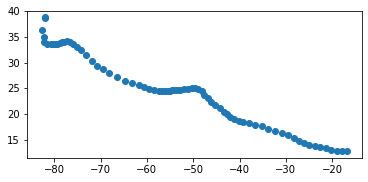

In [3]:
stormcode = "al062018"
base = "https://www.nhc.noaa.gov/gis/best_track/"
url = base + stormcode + "_best_track.zip"

shapefile = gpd.read_file(url)
display(shapefile)   
shapefile.plot()

### Get the track geometry as a linestring

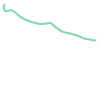

In [4]:
pts = shapefile.geometry
# make pts into line string
track = shp.LineString([pts[ii].coords[0] for ii in range(0,len(pts))])
display(track)

### Along-track perturbation

In [5]:
# get the coordinates of the track in a list
track_coords = list(track.coords)

# extrapolation ratio
extrap_rat = 10
# append point to the beginning for going in negative direction
p1 = track_coords[0]
p2 = track_coords[1]
b = (p1[0]-extrap_rat*(p2[0]-p1[0]), p1[1]-extrap_rat*(p2[1]-p1[1]) )
track_coords.insert(0,b)
# append point to the end for going in postive direction
p1 = track_coords[-2]
p2 = track_coords[-1]
b = (p1[0]+extrap_rat*(p2[0]-p1[0]), p1[1]+extrap_rat*(p2[1]-p1[1]) )
track_coords.append(b)

# specify along track error
along_track_error = -6.8 #[nm]
nm2m = 1852 # nautical miles to meters
along_track_error = along_track_error*nm2m
along_sign = int(np.sign(along_track_error))
along_error = abs(along_track_error)
#print(along_error)

# loop over all coordinates
for ii in range(1,len(track_coords)-1):
    # get the utm projection for middle longitude
    myProj = utm_proj_from_lon(track_coords[ii][0])
    pts = list()
    for jj in range(0, along_sign*10, along_sign):
        ind = ii + jj
        if ind < 0 or ind > len(track_coords)-1:
            continue
        # get the x,y utm coordinate for this line string
        x_utm, y_utm = myProj(track_coords[ind][0], track_coords[ind][1], inverse=False)
        pts.append((x_utm,y_utm))
    # make the temporary line segment 
    line_segment = shp.LineString([pts[pp] for pp in range(0,len(pts))])
    # interpolate a distance "along_error" along the line
    pnew = line_segment.interpolate(along_error)
    #p1 = line_segment[1] #origin
    #p2 = line_segment[1+int(np.sign(along_track_error))] #p2 is based on sign of error
    #angle = np.arctan2(p2[1]-p1[1],p2[0]-p1[0])                         
    #pnew = (p1[0]+abs(along_track_error)*np.cos(angle), p1[1]+abs(along_track_error)*np.sin(angle) )
    #print(pnew)
    # get back lat-lon
    lon, lat = myProj(pnew.coords[0][0], pnew.coords[0][1], inverse=True)
    print(track_coords[ii-1:ii+2])
    print([lon,lat])

[(-6.899999999999999, 12.8), (-16.9, 12.8), (-17.9, 12.8)]
[-16.78403765087225, 12.802183378438517]
[(-16.9, 12.8), (-17.9, 12.8), (-19.0, 12.8)]
[-17.78409613947234, 12.800194782467313]
[(-17.9, 12.8), (-19.0, 12.8), (-20.2, 13.1)]
[-18.884031214938222, 12.800216926353075]
[(-19.0, 12.8), (-20.2, 13.1), (-21.4, 13.4)]
[-20.087378921247, 13.072105321267362]
[(-20.2, 13.1), (-21.4, 13.4), (-22.6, 13.6)]
[-21.2872366299303, 13.37208139490917]
[(-21.4, 13.4), (-22.6, 13.6), (-23.8, 13.8)]
[-22.48523432216505, 13.581139277383654]
[(-22.6, 13.6), (-23.8, 13.8), (-24.9, 14.0)]
[-23.685224075300326, 13.781145212626965]
[(-23.8, 13.8), (-24.9, 14.0), (-26.1, 14.3)]
[-24.78539103613837, 13.979402575946946]
[(-24.9, 14.0), (-26.1, 14.3), (-27.2, 14.8)]
[-25.98683929427264, 14.2719942042631]
[(-26.1, 14.3), (-27.2, 14.8), (-28.3, 15.4)]
[-27.0938504800864, 14.752073899099559]
[(-27.2, 14.8), (-28.3, 15.4), (-29.6, 15.9)]
[-28.19756455980997, 15.344506217429966]
[(-28.3, 15.4), (-29.6, 15.9), (-30

### Plotting comparison to surface temperatures

In [6]:
coordinates = iter(zip([x_utm,x_utm],[y_utm, y_utm],[1, 1]))
x1, y1, z1 = coordinates.n
for x2, y2 ,z in coordinates:
    print(x2)
    print(y2)
    print(z)

AttributeError: 'zip' object has no attribute 'n'

In [ ]:
1+int(np.sign(along_track_error))

In [ ]:
lon,lat = myProj(line_segment[1][0], line_segment[1][1], inverse=True)
print([lon,lat])

In [ ]:
line_segment[2]

In [ ]:
len(track_coords)

In [ ]:
track.interpolate()

In [ ]:
pnew.coords[0][0]

In [ ]:
print(track.interpolate(80))

In [ ]:
for ii in range(5, -1, -1):
    print(ii)

In [ ]:
track = shp.LineString([track_coords[ii] for ii in range(0,len(track_coords))])
display(track)

In [ ]:
track.length

In [ ]:
along_sign = int(np.sign(along_track_error))

In [ ]:
pts = shapefile.geometry
pts

In [ ]:
print(track)

22.999587305672687
22.26041630228722


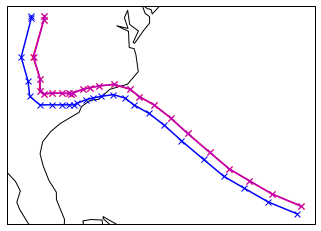

In [244]:
from random import random
pts = shapefile.geometry
errors = list()
[errors.append(+(n+1)/100) for n in range(0,len(pts)) ] 

# offset the point coordinates by "error"
pn = offset(pts,errors,dist_check=False)
pnd = offset(pts,errors,dist_check=True)

# original track linestring
orig_track = shp.LineString([pts[ii].coords[0] for ii in range(len(pn)-25,len(pts))])
# new track linestring
new_track = shp.LineString([pn[ii] for ii in range(len(pn)-25,len(pn))])
# new track linestring
new_trackd = shp.LineString([pnd[ii] for ii in range(len(pn)-25,len(pn))])

ax = plt.axes(projection=ccrs.PlateCarree())
plt.plot(*orig_track.xy,'b-x')
plt.plot(*new_track.xy,'rx-')
plt.plot(*new_trackd.xy,'mx-')
ax.coastlines()

print(orig_track.length)
print(new_track.length)

In [73]:
p1 = pts[0].coords[0]
p2 = pts[0+1].coords[0]    
print(p1)
print(p2)

(-16.9, 12.8)
(-17.9, 12.8)


In [82]:
pn[0]

(-20.18458593317693, 13.16165626729227)

In [ ]:
next(iter(zip(p1,[0, 0.5])))

In [127]:
np.hypot

<ufunc 'hypot'>